In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
np.random.seed(42)


In [4]:
# Step 1: Data Collection
# Upload the dataset to Google Colab and load it
# In Colab, use the file upload feature or mount Google Drive
# Example: Upload 'Cryptocurrency Volatility Prediction.csv' manually
from google.colab import files
uploaded = files.upload()

Saving Cryptocurrency Volatility Prediction.csv to Cryptocurrency Volatility Prediction.csv


In [5]:
# Load the dataset
df = pd.read_csv('Cryptocurrency Volatility Prediction.csv')

In [6]:
# Step 2: Data Preprocessing
# Handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
Unnamed: 0     0
open           0
high           0
low            0
close          0
volume         0
marketCap      0
timestamp      0
crypto_name    0
date           0
dtype: int64


In [7]:
# Drop rows with missing values (if any)
df = df.dropna()

In [8]:
# Filter for Bitcoin data (for simplicity; can extend to other cryptocurrencies)
df_bitcoin = df[df['crypto_name'] == 'Bitcoin'].copy()

In [9]:
# Convert timestamp to datetime and set as index
df_bitcoin['timestamp'] = pd.to_datetime(df_bitcoin['timestamp'])
df_bitcoin.set_index('timestamp', inplace=True)

In [10]:
# Normalize numerical features
scaler = MinMaxScaler()
numerical_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
df_bitcoin[numerical_cols] = scaler.fit_transform(df_bitcoin[numerical_cols])

In [11]:
# Step 3: Exploratory Data Analysis (EDA)
# Summary statistics
print("\nSummary Statistics for Bitcoin:")
print(df_bitcoin.describe())


Summary Statistics for Bitcoin:
         Unnamed: 0         open         high          low        close  \
count   3248.000000  3248.000000  3248.000000  3248.000000  3248.000000   
mean   20462.924877     0.142468     0.143536     0.140804     0.142613   
std    20697.119544     0.223072     0.224801     0.220215     0.223143   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%     3865.000000     0.005654     0.005560     0.005705     0.005655   
50%    11320.500000     0.054659     0.055310     0.054149     0.054844   
75%    33649.250000     0.142731     0.143136     0.142448     0.142800   
max    72912.000000     1.000000     1.000000     1.000000     1.000000   

            volume    marketCap  
count  3248.000000  3248.000000  
mean      0.035430     0.138937  
std       0.053783     0.222869  
min       0.000000     0.000000  
25%       0.000108     0.004506  
50%       0.007080     0.050349  
75%       0.060852     0.136864  
max       1.000000 

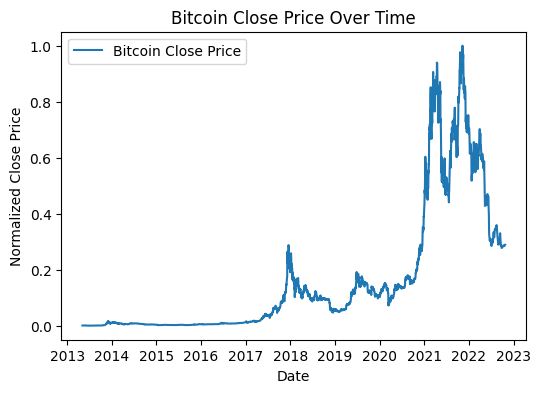

In [13]:
# Visualize price trends
plt.figure(figsize=(6, 4))
plt.plot(df_bitcoin.index, df_bitcoin['close'], label='Bitcoin Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

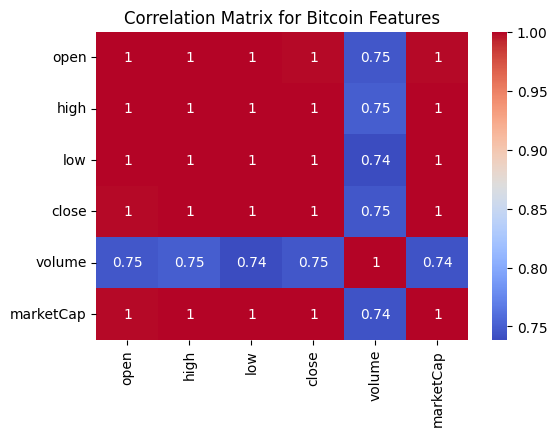

In [12]:
# Correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df_bitcoin[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Bitcoin Features')
plt.show()

In [14]:
# Step 4: Feature Engineering
# Calculate daily returns
df_bitcoin['returns'] = df_bitcoin['close'].pct_change()

In [15]:
# Calculate volatility (standard deviation of returns over a rolling window)
df_bitcoin['volatility'] = df_bitcoin['returns'].rolling(window=7).std()

In [16]:
# Calculate moving averages
df_bitcoin['ma7'] = df_bitcoin['close'].rolling(window=7).mean()
df_bitcoin['ma14'] = df_bitcoin['close'].rolling(window=14).mean()

In [18]:
# Calculate Bollinger Bands
df_bitcoin['bb_upper'] = df_bitcoin['ma14'] + (df_bitcoin['close'].rolling(window=14).std() * 2)
df_bitcoin['bb_lower'] = df_bitcoin['ma14'] - (df_bitcoin['close'].rolling(window=14).std() * 2)

In [19]:
# Calculate liquidity ratio (volume/marketCap)
df_bitcoin['liquidity_ratio'] = df_bitcoin['volume'] / df_bitcoin['marketCap']

In [20]:
# Drop rows with NaN values created by rolling calculations
df_bitcoin = df_bitcoin.dropna()

In [21]:
# Step 5: Model Selection
# Prepare features and target
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'ma7', 'ma14', 'bb_upper', 'bb_lower', 'liquidity_ratio']
target = 'volatility'
X = df_bitcoin[features]
y = df_bitcoin[target]

In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [23]:
# Initialize and train RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
# Step 6: Model Evaluation
# Make predictions
y_pred = model.predict(X_test)

In [25]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [26]:
print("\nModel Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")


Model Evaluation Metrics:
RMSE: 0.0231
MAE: 0.0199
R^2 Score: -0.7575


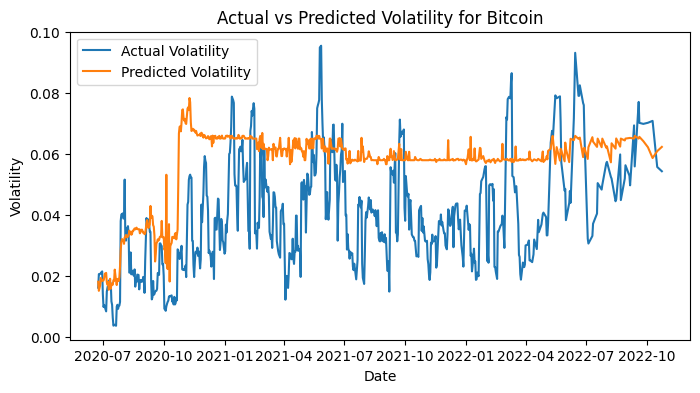

In [29]:
# Visualize actual vs predicted volatility
plt.figure(figsize=(8, 6))
plt.plot(y_test.index, y_test, label='Actual Volatility')
plt.plot(y_test.index, y_pred, label='Predicted Volatility')
plt.title('Actual vs Predicted Volatility for Bitcoin')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [28]:
# Step 7: Model Optimization
# Basic hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)


Best Parameters from Grid Search:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [30]:
# Train optimized model
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)

In [31]:
# Evaluate optimized model
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
mae_opt = mean_absolute_error(y_test, y_pred_optimized)
r2_opt = r2_score(y_test, y_pred_optimized)

print("\nOptimized Model Evaluation Metrics:")
print(f"RMSE: {rmse_opt:.4f}")
print(f"MAE: {mae_opt:.4f}")
print(f"R^2 Score: {r2_opt:.4f}")


Optimized Model Evaluation Metrics:
RMSE: 0.0240
MAE: 0.0210
R^2 Score: -0.8932


In [32]:
# Step 8: Local Deployment (Streamlit)
# Save the model for deployment
import joblib
joblib.dump(best_model, 'crypto_volatility_model.pkl')

['crypto_volatility_model.pkl']

In [33]:
# Example Streamlit app code (run this in a separate .py file or local environment)
"""
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# Load the model
model = joblib.load('crypto_volatility_model.pkl')

# Streamlit app
st.title('Cryptocurrency Volatility Prediction')
st.write('Enter the following features to predict Bitcoin volatility:')

# Input fields
open_price = st.number_input('Open Price', value=0.0)
high_price = st.number_input('High Price', value=0.0)
low_price = st.number_input('Low Price', value=0.0)
close_price = st.number_input('Close Price', value=0.0)
volume = st.number_input('Volume', value=0.0)
market_cap = st.number_input('Market Cap', value=0.0)
ma7 = st.number_input('7-Day Moving Average', value=0.0)
ma14 = st.number_input('14-Day Moving Average', value=0.0)
bb_upper = st.number_input('Bollinger Band Upper', value=0.0)
bb_lower = st.number_input('Bollinger Band Lower', value=0.0)
liquidity_ratio = st.number_input('Liquidity Ratio', value=0.0)

# Prepare input data
input_data = np.array([[open_price, high_price, low_price, close_price, volume, market_cap, ma7, ma14, bb_upper, bb_lower, liquidity_ratio]])

# Predict
if st.button('Predict Volatility'):
    prediction = model.predict(input_data)
    st.write(f'Predicted Volatility: {prediction[0]:.6f}')
"""

"\n%%writefile app.py\nimport streamlit as st\nimport pandas as pd\nimport joblib\nimport numpy as np\n\n# Load the model\nmodel = joblib.load('crypto_volatility_model.pkl')\n\n# Streamlit app\nst.title('Cryptocurrency Volatility Prediction')\nst.write('Enter the following features to predict Bitcoin volatility:')\n\n# Input fields\nopen_price = st.number_input('Open Price', value=0.0)\nhigh_price = st.number_input('High Price', value=0.0)\nlow_price = st.number_input('Low Price', value=0.0)\nclose_price = st.number_input('Close Price', value=0.0)\nvolume = st.number_input('Volume', value=0.0)\nmarket_cap = st.number_input('Market Cap', value=0.0)\nma7 = st.number_input('7-Day Moving Average', value=0.0)\nma14 = st.number_input('14-Day Moving Average', value=0.0)\nbb_upper = st.number_input('Bollinger Band Upper', value=0.0)\nbb_lower = st.number_input('Bollinger Band Lower', value=0.0)\nliquidity_ratio = st.number_input('Liquidity Ratio', value=0.0)\n\n# Prepare input data\ninput_data

In [34]:
# Step 9: Save Outputs for Submission
# Save EDA plots
plt.figure(figsize=(6, 4))
plt.plot(y_test.index, y_test, label='Actual Volatility')
plt.plot(y_test.index, y_pred_optimized, label='Predicted Volatility (Optimized)')
plt.title('Actual vs Predicted Volatility (Optimized Model)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.savefig('volatility_prediction.png')
plt.close()

In [35]:
# Save dataset with engineered features
df_bitcoin.to_csv('processed_bitcoin_data.csv')

# Save evaluation metrics
with open('model_evaluation.txt', 'w') as f:
    f.write(f"RMSE: {rmse_opt:.4f}\nMAE: {mae_opt:.4f}\nR^2 Score: {r2_opt:.4f}")

print("\nFiles saved: processed_bitcoin_data.csv, volatility_prediction.png, model_evaluation.txt")


Files saved: processed_bitcoin_data.csv, volatility_prediction.png, model_evaluation.txt


In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# Loading the dataset
df = pd.read_csv("Cryptocurrency Volatility Prediction.csv")

# Filtering for Bitcoin data
bitcoin_df = df[df['crypto_name'] == 'Bitcoin'].copy()

# Handling zero values in volume
bitcoin_df['volume'] = bitcoin_df['volume'].replace(0, np.nan).fillna(method='ffill')

# Feature engineering
# Calculating daily returns
bitcoin_df['daily_return'] = (bitcoin_df['close'] - bitcoin_df['open']) / bitcoin_df['open']

# Calculating volatility (7-day rolling standard deviation of returns)
bitcoin_df['volatility'] = bitcoin_df['daily_return'].rolling(window=7).std()

# Adding moving average (7-day)
bitcoin_df['ma7'] = bitcoin_df['close'].rolling(window=7).mean()

# Adding liquidity ratio
bitcoin_df['liquidity_ratio'] = bitcoin_df['volume'] / bitcoin_df['marketCap']

# Adding high-low spread
bitcoin_df['high_low_spread'] = bitcoin_df['high'] - bitcoin_df['low']

# Dropping rows with NaN values from rolling calculations
bitcoin_df = bitcoin_df.dropna()

# Converting date to datetime for splitting
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])

# Defining features and target
features = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'ma7', 'liquidity_ratio', 'high_low_spread']
X = bitcoin_df[features]
y = bitcoin_df['volatility']

# Normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-based train-test split (2013–2020 for training, 2021–2022 for testing)
train_mask = bitcoin_df['date'] < '2021-01-01'
test_mask = bitcoin_df['date'] >= '2021-01-01'
X_train = X_scaled[train_mask]
y_train = y[train_mask]
X_test = X_scaled[test_mask]
y_test = y[test_mask]

# Training Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing evaluation metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Saving the trained model
joblib.dump(model, 'random_forest_volatility_model.pkl')

RMSE: 0.0206
MAE: 0.0178
R² Score: -1.0265


['random_forest_volatility_model.pkl']